In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
import seaborn as sns

In [2]:
import ranking_funcs

/Users/wangning/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df=ranking_funcs.read_imdb_movie_actor_data('ranking_data_sets/imdb_movie_stars.csv')
df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,...,Documentary,Sport,Musical,Animation,Western,Mystery,History,Action,Adventure,War
0,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0087800,tt0087800,7.0,3,...,0,0,0,0,0,0,0,0,0,0
1,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0089839,tt0089839,5.0,0,...,0,0,0,0,0,0,0,0,0,0
2,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0099329,tt0099329,6.0,2,...,0,0,1,0,0,0,0,0,0,0
3,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0099487,tt0099487,8.0,3,...,0,0,0,0,0,0,0,0,0,0
4,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0106307,tt0106307,7.0,1,...,0,0,0,0,0,0,0,0,0,0


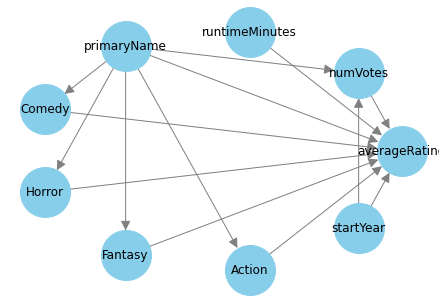

In [4]:
G = nx.DiGraph()

nodes = ["averageRating", "numVotes", "runtimeMinutes", "primaryName", "Comedy", "Horror", "Fantasy", "Action", "startYear"]
G.add_nodes_from(nodes)


edges = [
    ("primaryName", "averageRating"), 
    ("primaryName", "numVotes"),
    ("primaryName", "Comedy"),
    ("primaryName", "Horror"),
    ("primaryName", "Fantasy"),
    ("primaryName", "Action"),
    ("numVotes", "averageRating"),
    ("runtimeMinutes", "averageRating"),
    ("Comedy", "averageRating"),
    ("Horror", "averageRating"),
    ("Fantasy", "averageRating"),
    ("Action", "averageRating"),
    ("startYear", "averageRating"),
    ("startYear", "numVotes")
]
G.add_edges_from(edges)


layout = nx.circular_layout(G)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=2500, edge_color='gray', arrowsize=20, pos=layout)

plt.savefig(f'ranking_plots/causal_graph_imdb.png')
plt.show()

In [5]:
new_G=ranking_funcs.get_new_G(G,df)
new_G_combined=ranking_funcs.get_new_G_combined(G,df)

In [10]:
df[df['primaryTitle']=='Ghost in the Shell']

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,...,Documentary,Sport,Musical,Animation,Western,Mystery,History,Action,Adventure,War
151,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt1219827,tt1219827,6.0,3,...,0,0,0,0,0,0,0,1,0,0


In [8]:
df.sort_values(by='averageRating',ascending=False)[['primaryTitle','primaryName','averageRating']]

,primaryTitle,primaryName,averageRating
69,Schindler's List,6,9.0
249,Long Da Lishkara,7,9.0
156,Captain America: The Winter Soldier,0,8.0
56,Gandhi,6,8.0
103,Shutter Island,6,8.0
...,...,...,...
97,The Ten Commandments,6,3.0
89,BloodRayne,6,3.0
320,Vigilante,2,3.0
311,Gul Makai,7,3.0


In [11]:
ordered_df=df.sort_values(by='averageRating',ascending=False)[['primaryTitle','primaryName','averageRating']].reset_index()

In [12]:
ordered_df[ordered_df['primaryTitle']=='Ghost in the Shell']

,index,primaryTitle,primaryName,averageRating
231,151,Ghost in the Shell,0,6.0


In [14]:
ordered_df[ordered_df['primaryTitle']=='Aquaman']

,index,primaryTitle,primaryName,averageRating
104,197,Aquaman,4,7.0


In [15]:
new_rank_gs=ranking_funcs.get_ranking_query(new_G, df, len(df), {'primaryName':5}, 'averageRating', {'primaryTitle':'Ghost in the Shell'}, opt="fix")[['primaryTitle','primaryName','averageRating']].reset_index()
new_rank_gs[new_rank_gs['primaryTitle']=='Ghost in the Shell']

,index,primaryTitle,primaryName,averageRating
271,151,Ghost in the Shell,5,5.229998


In [18]:
new_rank_gs=ranking_funcs.get_ranking_query(new_G_combined, df, len(df), {'primaryName':5}, 'averageRating', {'primaryTitle':'Ghost in the Shell'}, opt="fix")[['primaryTitle','primaryName','averageRating']].reset_index()
new_rank_gs[new_rank_gs['primaryTitle']=='Ghost in the Shell']

,index,primaryTitle,primaryName,averageRating
271,151,Ghost in the Shell,5,5.429581


In [19]:
new_rank_aq=ranking_funcs.get_ranking_query(new_G, df, len(df), {'primaryName':3}, 'averageRating', {'primaryTitle':'Aquaman'}, opt="fix")[['primaryTitle','primaryName','averageRating']].reset_index()
new_rank_aq[new_rank_aq['primaryTitle']=='Aquaman']

,index,primaryTitle,primaryName,averageRating
54,197,Aquaman,3,7.154


In [23]:
new_rank_aqs=ranking_funcs.get_ranking_query(new_G_combined, df, len(df), {'primaryName':3}, 'averageRating', {'primaryTitle':'Aquaman'}, opt="fix")[['primaryTitle','primaryName','averageRating']].reset_index()
new_rank_aqs[new_rank_aqs['primaryTitle']=='Aquaman']

,index,primaryTitle,primaryName,averageRating
54,197,Aquaman,3,7.114084


In [25]:
for n in nodes:
    print((n,ranking_funcs.find_backdoor_sets_opt(G, "averageRating", n)))

('averageRating', None)
('numVotes', [frozenset({'primaryName', 'startYear'})])
('runtimeMinutes', None)
('primaryName', None)
('Comedy', [frozenset({'primaryName'})])
('Horror', [frozenset({'primaryName'})])
('Fantasy', [frozenset({'primaryName'})])
('Action', [frozenset({'primaryName'})])
('startYear', None)


In [26]:
X=df[["numVotes", "runtimeMinutes", "primaryName", "Comedy", "Horror", "Fantasy", "Action", "startYear"]]
y=df["averageRating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [ ]:
%%capture
###random forest with variables selected by the importance plot
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=123)
rf_cv = GridSearchCV(rf,param_grid, cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)

/Users/wangning/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


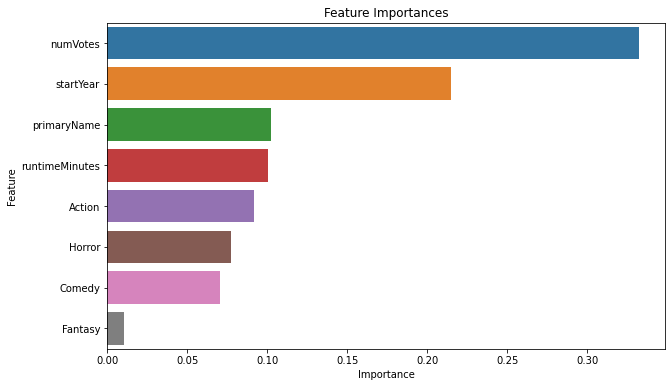

In [29]:
importances = RandomForestRegressor(**rf_cv.best_params_, random_state=123).fit(X_train, y_train).feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

In [30]:
rf_estimator=RandomForestRegressor(**rf_cv.best_params_, random_state=123).fit(X, y)

/Users/wangning/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [32]:
updated_df=ranking_funcs.get_ranking_query(new_G, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':3},"fix")

In [35]:
updated_df_X=updated_df[["numVotes", "runtimeMinutes", "primaryName", "Comedy", "Horror", "Fantasy", "Action", "startYear"]]
updated_df_y=updated_df["averageRating"]

In [38]:
rf_result=rf_estimator.predict(updated_df_X)

In [39]:
updated_df['rf_prediction']=rf_result

In [43]:
rf_order=updated_df.sort_values(by='rf_prediction',ascending=False)
rf_order

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,...,Sport,Musical,Animation,Western,Mystery,History,Action,Adventure,War,rf_prediction
69,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.000000,3,...,0,0,0,0,0,1,0,0,0,7.900859
56,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0083987,tt0083987,8.000000,3,...,0,0,0,0,0,1,0,0,0,7.900859
145,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0482571,tt0482571,8.000000,3,...,0,0,0,0,1,0,0,0,0,7.743457
142,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0416320,tt0416320,8.000000,3,...,0,0,0,0,0,0,0,0,0,7.743457
11,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0118768,tt0118768,6.601145,3,...,0,0,0,0,0,0,0,0,0,7.730607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,nm0597388,4,1979,\N,"actor,producer,writer","tt5433140,tt0974015,tt1477834,tt4334266",tt2769184,tt2769184,4.000000,0,...,0,0,0,0,0,0,0,0,0,4.635060
86,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0318081,tt0318081,4.000000,1,...,0,0,0,0,0,0,1,1,0,4.627385
89,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0383222,tt0383222,3.000000,1,...,0,0,0,0,0,0,1,0,0,4.627385
201,nm0597388,4,1979,\N,"actor,producer,writer","tt5433140,tt0974015,tt1477834,tt4334266",tt4334266,tt4334266,5.000000,1,...,0,0,0,0,1,0,1,0,0,4.491929


In [50]:
true_top_5=updated_df.head(5).index
true_top_5

Int64Index([69, 249, 41, 227, 164], dtype='int64')

In [49]:
top_5_rf = rf_order.head(5).index
top_5_rf

Int64Index([69, 56, 145, 142, 11], dtype='int64')

In [52]:
ranking_funcs.accuracy_in_topk(top_5_rf,true_top_5)

0.2

In [53]:
ranking_funcs.accuracy_topk_rank(rf_order.index,updated_df.index)

0.008902077151335312

In [56]:
backdoor_2_preds=ranking_funcs.predict_backdoor_opt2(new_G, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':3},"fix")

In [61]:
ranking_funcs.accuracy_topk_rank(backdoor_2_preds['row_index'].to_list(),updated_df.index)

0.005934718100890208

In [62]:
backdoor_2_preds_cg=ranking_funcs.predict_backdoor_opt2(new_G_combined, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':3},"fix")

In [63]:
ranking_funcs.accuracy_topk_rank(backdoor_2_preds_cg['row_index'].to_list(),updated_df.index)

0.01483679525222552

In [64]:
backdoor_1_preds=ranking_funcs.predict_backdoor_opt(new_G, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':3},"fix")

In [65]:
ranking_funcs.accuracy_topk_rank(backdoor_1_preds['row_index'].to_list(),updated_df.index)

0.005934718100890208

In [68]:
backdoor_1_preds_cg=ranking_funcs.predict_backdoor_opt(new_G_combined, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':3},"fix")

In [69]:
ranking_funcs.accuracy_topk_rank(backdoor_1_preds_cg['row_index'].to_list(),updated_df.index)

0.005934718100890208

In [71]:
for i in range(10):
    print(i+1)

1
2
3
4
5
6
7
8
9
10


In [177]:
rf_results=[]
rf_results_in_topk=[]

back_door_opt1_with_G=[]
back_door_opt1_with_G_in_topk=[]

back_door_opt1_with_combined_G=[]
back_door_opt1_with_combined_G_in_topk=[]

back_door_opt2_with_G=[]
back_door_opt2_with_G_in_topk=[]

back_door_opt2_with_combined_G=[]
back_door_opt2_with_combined_G_in_topk=[]

for i in range(1,len(updated_df)+1):
    rf_results.append(ranking_funcs.accuracy_topk_rank(rf_order.head(i).index,updated_df.head(i).index))
    rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_order.head(i).index,updated_df.head(i).index))

    back_door_opt1_with_G.append(ranking_funcs.accuracy_topk_rank(backdoor_1_preds['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt1_with_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_1_preds['row_index'].head(i).to_list(),updated_df.head(i).index))
    
    back_door_opt1_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt1_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    
    back_door_opt2_with_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_preds['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt2_with_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_preds['row_index'].head(i).to_list(),updated_df.head(i).index))
    
    back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_preds['row_index'].head(i).to_list(),updated_df.head(i).index))

In [178]:
df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method1':back_door_opt1_with_G,
                               'backdoor_method1_with_combined_effect':back_door_opt1_with_combined_G,
                               'backdoor_method2':back_door_opt2_with_G,
                                'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,
                               'k_range':range(1,len(updated_df)+1)})

df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method1':back_door_opt1_with_G_in_topk,
                               'backdoor_method1_with_combined_effect':back_door_opt1_with_combined_G_in_topk,
                               'backdoor_method2':back_door_opt2_with_G_in_topk,
                                'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                'k_range':range(1,len(updated_df)+1)})

In [89]:
df_top_k_accuracy

,random_forest,backdoor_method1,backdoor_method1_with_combined_effect,backdoor_method2,backdoor_method2_with_combined_effect,k_range
0,1.000000,1.000000,1.000000,1.000000,1.000000,1
1,0.500000,0.500000,0.500000,0.500000,0.500000,2
2,0.333333,0.333333,0.333333,0.333333,0.333333,3
3,0.250000,0.250000,0.250000,0.250000,0.250000,4
4,0.200000,0.200000,0.200000,0.200000,0.200000,5
...,...,...,...,...,...,...
332,0.009009,0.003003,0.003003,0.003003,0.012012,333
333,0.008982,0.002994,0.002994,0.002994,0.011976,334
334,0.008955,0.002985,0.002985,0.002985,0.011940,335
335,0.008929,0.002976,0.002976,0.002976,0.011905,336


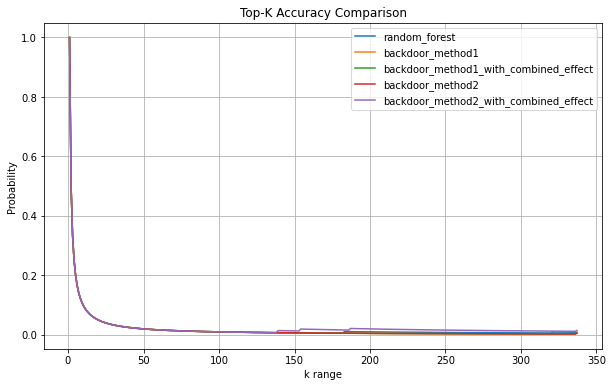

In [179]:
plt.figure(figsize=(10, 6))
for column in df_top_k_accuracy.columns[:-1]:
    plt.plot(df_top_k_accuracy["k_range"], df_top_k_accuracy[column], label=column)

plt.xlabel("k range")
plt.ylabel("Probability")
plt.title("Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/top_k_comparison.png')

In [90]:
df_in_top_k_accuracy

,random_forest,backdoor_method1,backdoor_method1_with_combined_effect,backdoor_method2,backdoor_method2_with_combined_effect,k_range
0,1.000000,1.000000,1.000000,1.000000,1.000000,1
1,0.500000,0.500000,0.500000,0.500000,0.500000,2
2,0.333333,0.333333,0.333333,0.333333,0.333333,3
3,0.250000,0.250000,0.250000,0.250000,0.250000,4
4,0.200000,0.200000,0.200000,0.200000,0.200000,5
...,...,...,...,...,...,...
332,0.990991,0.990991,0.990991,0.993994,0.993994,333
333,0.991018,0.994012,0.994012,0.997006,0.997006,334
334,0.994030,0.997015,0.997015,0.997015,0.997015,335
335,0.997024,1.000000,1.000000,1.000000,1.000000,336


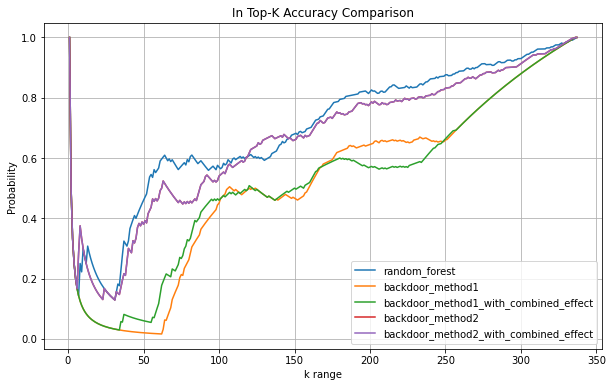

In [180]:
plt.figure(figsize=(10, 6))
for column in df_in_top_k_accuracy.columns[:-1]:
    plt.plot(df_in_top_k_accuracy["k_range"], df_in_top_k_accuracy[column], label=column)

plt.xlabel("k range")
plt.ylabel("Probability")
plt.title("In Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/In_top_k_comparison_{x}.png')
plt.show()

In [97]:
backdoor_1_preds

,row_index,expected_value
0,69,7.202203
231,157,7.202203
209,45,7.202203
211,38,7.202203
212,39,7.202203
...,...,...
220,303,6.147940
222,233,6.147940
223,177,6.147940
224,118,6.147940


In [107]:
updated_df['true_row_index']=updated_df.index

In [104]:
merged_df=updated_df.merge(backdoor_2_preds_cg,how='left', left_index=True,right_on='row_index')

In [106]:
merged_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,...,Western,Mystery,History,Action,Adventure,War,rf_prediction,true_row_index,row_index,expected_value
0,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.000000,3,...,0,0,1,0,0,0,7.900859,69,69,8.500000
1,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0308513,tt0308513,9.000000,0,...,0,0,0,0,0,0,7.175146,249,249,6.863636
2,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt1333667,tt1333667,8.601145,3,...,0,0,0,0,0,0,7.089043,41,41,7.065432
10,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0177490,tt0177490,8.000000,0,...,0,0,0,0,0,0,7.175146,227,227,6.863636
12,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt3498820,tt3498820,8.000000,3,...,0,0,0,1,0,0,7.369595,164,164,7.153846


In [118]:
merged_df

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,...,Western,Mystery,History,Action,Adventure,War,rf_prediction,true_row_index,row_index,expected_value
0,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.000000,3,...,0,0,1,0,0,0,7.900859,69,69,8.500000
1,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0308513,tt0308513,9.000000,0,...,0,0,0,0,0,0,7.175146,249,249,6.863636
2,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt1333667,tt1333667,8.601145,3,...,0,0,0,0,0,0,7.089043,41,41,7.065432
10,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0177490,tt0177490,8.000000,0,...,0,0,0,0,0,0,7.175146,227,227,6.863636
12,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt3498820,tt3498820,8.000000,3,...,0,0,0,1,0,0,7.369595,164,164,7.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt4642936,tt4642936,3.000000,0,...,0,0,0,1,0,0,5.349445,301,301,5.391304
331,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0383222,tt0383222,3.000000,1,...,0,0,0,1,0,0,4.627385,89,89,5.600000
334,nm3053338,2,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt1489264,tt1489264,3.000000,0,...,0,0,0,1,0,0,4.922858,320,320,2.500000
333,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt8176312,tt8176312,3.000000,0,...,0,0,0,0,0,1,5.662730,311,311,5.391304


In [114]:
rf_order.index

Int64Index([ 69,  56, 145, 142,  11,  22,  21,  17,  12, 103,
            ...
            320, 181, 175, 319, 304, 199,  86,  89, 201, 191],
           dtype='int64', length=337)

In [117]:
backdoor_2_preds_cg['row_index']

0       69
9       56
4       43
7      103
25      91
      ... 
259    198
305    201
281    336
334    320
336    319
Name: row_index, Length: 337, dtype: int64

In [116]:
updated_df

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,...,Western,Mystery,History,Action,Adventure,War,rf_prediction,true_row_index,rf_ranking,backdoor_opt2_ranking
69,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.000000,3,...,0,0,1,0,0,0,7.900859,69,69,135
249,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0308513,tt0308513,9.000000,0,...,0,0,0,0,0,0,7.175146,249,56,178
41,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt1333667,tt1333667,8.601145,3,...,0,0,0,0,0,0,7.089043,41,145,24
227,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0177490,tt0177490,8.000000,0,...,0,0,0,0,0,0,7.175146,227,142,157
164,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt3498820,tt3498820,8.000000,3,...,0,0,0,1,0,0,7.369595,164,11,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt4642936,tt4642936,3.000000,0,...,0,0,0,1,0,0,5.349445,301,199,267
89,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0383222,tt0383222,3.000000,1,...,0,0,0,1,0,0,4.627385,89,86,205
320,nm3053338,2,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt1489264,tt1489264,3.000000,0,...,0,0,0,1,0,0,4.922858,320,89,287
311,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt8176312,tt8176312,3.000000,0,...,0,0,0,0,0,1,5.662730,311,201,181


In [120]:
updated_df.groupby('numVotes').apply(lambda x: x['true_row_index'].to_list())

numVotes
0    [249, 227, 106, 228, 258, 109, 204, 237, 299, ...
1    [252, 309, 196, 188, 137, 264, 313, 323, 226, ...
2    [85, 135, 150, 171, 143, 166, 153, 274, 294, 3...
3    [69, 41, 164, 167, 103, 56, 158, 156, 98, 91, ...
dtype: object

In [121]:
rf_order['true_row_index']=rf_order.index

In [122]:
rf_order

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,...,Musical,Animation,Western,Mystery,History,Action,Adventure,War,rf_prediction,true_row_index
69,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.000000,3,...,0,0,0,0,1,0,0,0,7.900859,69
56,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0083987,tt0083987,8.000000,3,...,0,0,0,0,1,0,0,0,7.900859,56
145,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0482571,tt0482571,8.000000,3,...,0,0,0,1,0,0,0,0,7.743457,145
142,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0416320,tt0416320,8.000000,3,...,0,0,0,0,0,0,0,0,7.743457,142
11,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0118768,tt0118768,6.601145,3,...,0,0,0,0,0,0,0,0,7.730607,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,nm0597388,4,1979,\N,"actor,producer,writer","tt5433140,tt0974015,tt1477834,tt4334266",tt2769184,tt2769184,4.000000,0,...,0,0,0,0,0,0,0,0,4.635060,199
86,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0318081,tt0318081,4.000000,1,...,0,0,0,0,0,1,1,0,4.627385,86
89,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0383222,tt0383222,3.000000,1,...,0,0,0,0,0,1,0,0,4.627385,89
201,nm0597388,4,1979,\N,"actor,producer,writer","tt5433140,tt0974015,tt1477834,tt4334266",tt4334266,tt4334266,5.000000,1,...,0,0,0,1,0,1,0,0,4.491929,201


In [124]:
rf_row=rf_order.groupby('numVotes').apply(lambda x: x['true_row_index'].to_list())

In [130]:
rf_row

numVotes
0    [224, 227, 256, 215, 249, 250, 212, 229, 204, ...
1    [99, 102, 77, 67, 88, 137, 71, 70, 235, 226, 1...
2    [85, 96, 140, 80, 135, 94, 324, 274, 294, 150,...
3    [69, 56, 145, 142, 11, 22, 21, 17, 12, 103, 7,...
dtype: object

In [131]:
merged_df=backdoor_2_preds_cg.merge(updated_df,how='left', right_index=True,left_on='row_index')

In [132]:
merged_df

,row_index,expected_value,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,...,Western,Mystery,History,Action,Adventure,War,rf_prediction,true_row_index,rf_ranking,backdoor_opt2_ranking
0,69,8.500000,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,...,0,0,1,0,0,0,7.900859,69,69,135
9,56,8.500000,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0083987,tt0083987,...,0,0,1,0,0,0,7.900859,56,17,8
4,43,8.333865,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt17277414,tt17277414,...,0,0,1,0,0,0,6.619793,43,147,6
7,103,7.666667,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt1130884,tt1130884,...,0,1,0,0,0,0,7.708275,103,21,325
25,91,7.666667,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0425210,tt0425210,...,0,0,0,0,0,0,7.145904,91,2,274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,198,5.333333,nm0597388,4,1979,\N,"actor,producer,writer","tt5433140,tt0974015,tt1477834,tt4334266",tt2386285,tt2386285,...,0,0,0,0,0,0,6.077887,198,189,51
305,201,5.333333,nm0597388,4,1979,\N,"actor,producer,writer","tt5433140,tt0974015,tt1477834,tt4334266",tt4334266,tt4334266,...,0,1,0,1,0,0,4.491929,201,110,76
281,336,5.000000,nm8076281,1,1996,\N,actress,"tt10366514,tt7657566,tt1517268,tt12374656",tt9778348,tt9778348,...,0,1,0,0,0,0,6.167407,336,116,319
334,320,2.500000,nm3053338,2,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt1489264,tt1489264,...,0,0,0,1,0,0,4.922858,320,89,287


In [134]:
true_row_indexes=updated_df.groupby("numVotes").apply(lambda x: x['true_row_index'].to_list())

In [145]:
len(true_row_indexes)

4

In [135]:
for i in true_row_indexes:
    print(i)

[249, 227, 106, 228, 258, 109, 204, 237, 299, 225, 224, 223, 220, 90, 210, 209, 81, 208, 207, 84, 206, 312, 305, 308, 180, 183, 176, 172, 159, 169, 205, 275, 276, 281, 282, 291, 317, 335, 265, 263, 211, 260, 212, 214, 216, 217, 218, 221, 222, 231, 234, 240, 243, 244, 255, 256, 132, 168, 129, 57, 107, 111, 59, 82, 60, 61, 63, 75, 74, 65, 72, 125, 246, 251, 248, 334, 230, 241, 239, 229, 257, 328, 306, 280, 298, 295, 292, 288, 286, 283, 279, 277, 273, 269, 303, 233, 177, 118, 198, 110, 190, 189, 187, 186, 185, 104, 178, 219, 170, 173, 200, 83, 215, 76, 213, 127, 174, 123, 121, 115, 284, 310, 300, 296, 297, 68, 336, 267, 175, 259, 261, 262, 58, 238, 266, 191, 270, 236, 66, 64, 232, 78, 184, 271, 247, 242, 199, 131, 126, 245, 285, 250, 290, 287, 289, 254, 112, 304, 302, 116, 181, 293, 278, 101, 97, 301, 320, 311, 319]
[252, 309, 196, 188, 137, 264, 313, 323, 226, 235, 102, 100, 99, 70, 88, 62, 67, 71, 122, 253, 272, 268, 322, 194, 113, 95, 179, 134, 77, 138, 124, 87, 119, 203, 120, 327, 201

In [149]:
for i in range(len(true_row_indexes)):
    print(i)

0
1
2
3


In [152]:
true_row_indexes.index[0]

0

In [151]:
true_row_indexes[0][0:5]

[249, 227, 106, 228, 258]

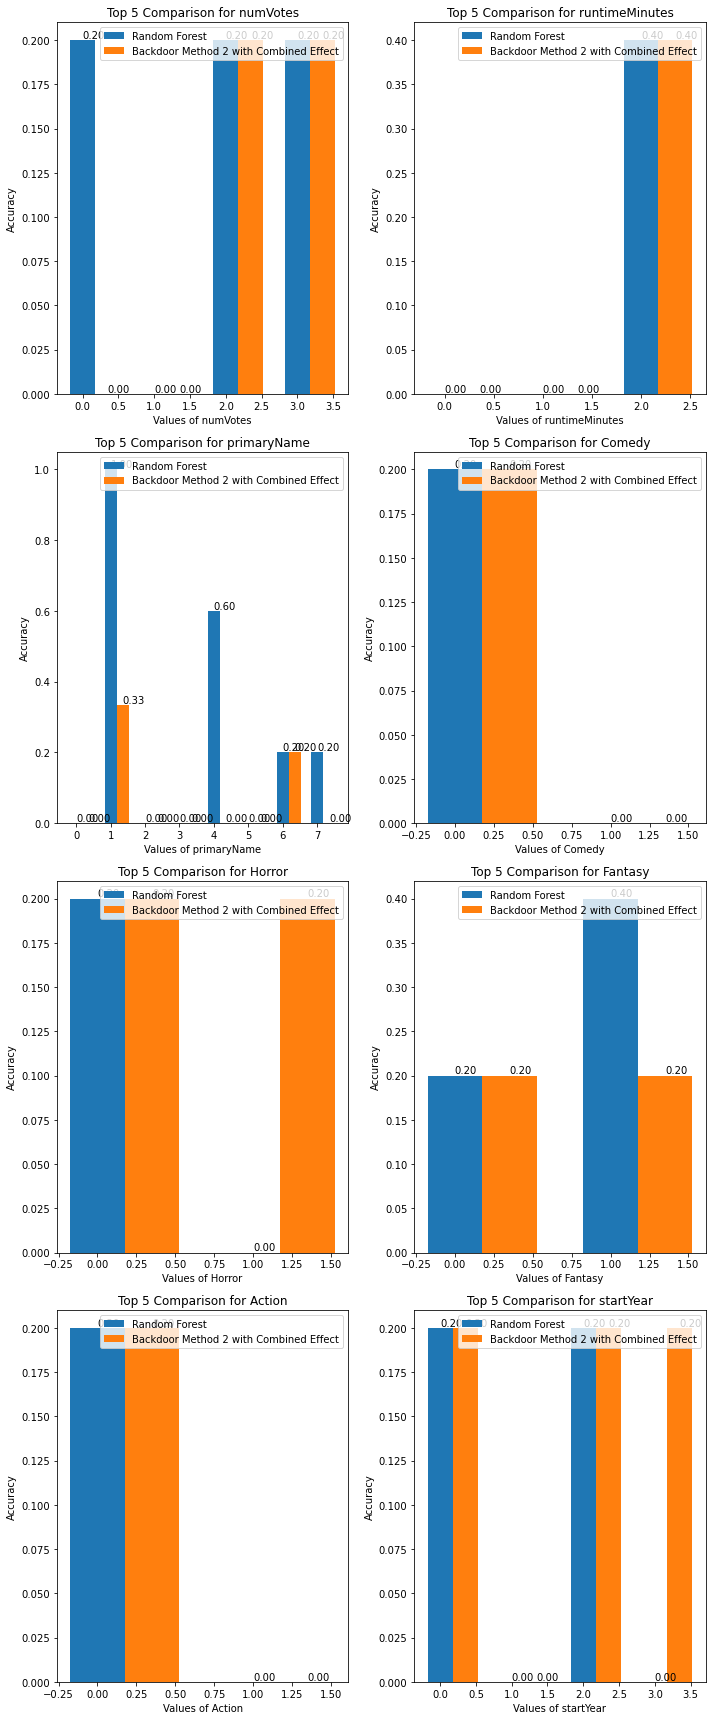

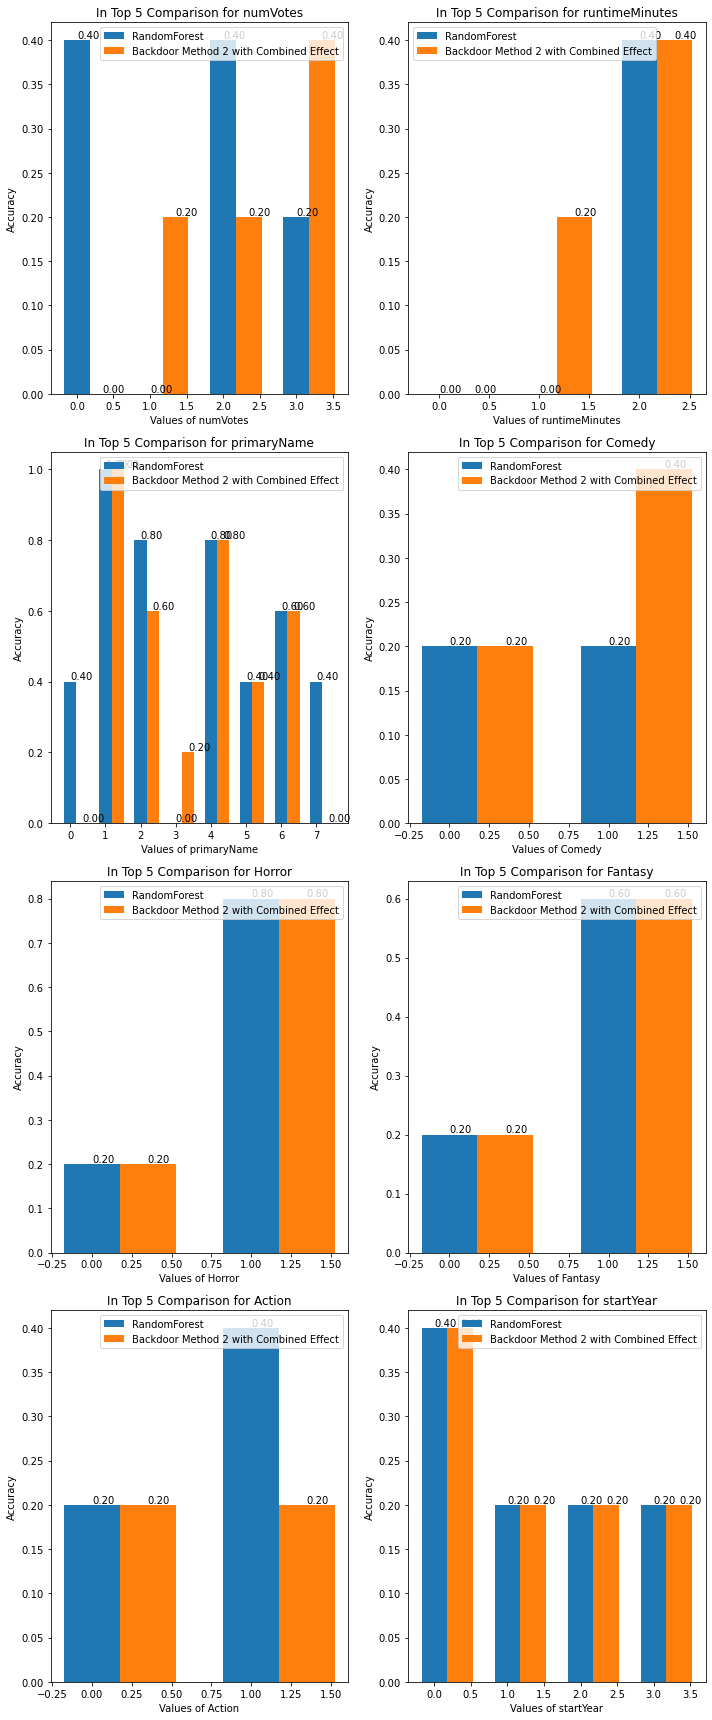

In [264]:
Xs = ["numVotes", "runtimeMinutes", "primaryName", "Comedy", "Horror", "Fantasy", "Action", "startYear"]


plt.figure(figsize=(10, 3 * len(Xs)))


for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    
    
    for i in range(len(true_row_indexes)):
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        x_val.append(true_row_indexes.index[i])
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                      x:x_val})
    
    plt.subplot(4, 2, index)
    bar_width = 0.35
    r1 = np.arange(len(df_top_k_accuracy))
    r2 = [x + bar_width for x in r1]

    bars1 = plt.bar(r1, df_top_k_accuracy['random_forest'], width=bar_width, label='Random Forest')
    bars2 = plt.bar(r2, df_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, label='Backdoor Method 2 with Combined Effect')
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom')
    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom')
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'Top 5 Comparison for {x}')
    plt.legend()
    
plt.tight_layout()
plt.savefig('ranking_plots/top_5_comparison_all_features.png')
plt.show()



plt.figure(figsize=(10, 3 * len(Xs)))

# Iterate for In Top 5 Comparison plots
for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    
    
    for i in range(len(true_row_indexes)):
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        x_val.append(true_row_indexes.index[i])
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                      x:x_val})
    plt.subplot(4, 2, index)
    bar_width = 0.35
    r1 = np.arange(len(df_in_top_k_accuracy))
    r2 = [x + bar_width for x in r1]

    bars1 = plt.bar(r1, df_in_top_k_accuracy['random_forest'], width=bar_width, label='RandomForest')
    bars2 = plt.bar(r2, df_in_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, label='Backdoor Method 2 with Combined Effect')
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom')
    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom')
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'In Top 5 Comparison for {x}')
    plt.legend()

plt.tight_layout()
plt.savefig('ranking_plots/in_top_5_comparison_all_features.png')
plt.show()


In [236]:
# Xs=["numVotes", "runtimeMinutes", "primaryName", "Comedy", "Horror", "Fantasy", "Action", "startYear"]

# for x in Xs:
#     rf_results=[]
#     rf_results_in_topk=[]
#     back_door_opt2_with_combined_G=[]
#     back_door_opt2_with_combined_G_in_topk=[]
#     x_val=[]
    
#     true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
#     rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
#     backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    
    
#     for i in range(len(true_row_indexes)):
#         rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
#         rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
#         back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
#         back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
#         x_val.append(true_row_indexes.index[i])
        
    
#     df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,x:x_val})
#     df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
#                                       x:x_val})

#     plt.figure(figsize=(10, 6))
#     bar_width = 0.35
#     r1 = np.arange(len(df_top_k_accuracy))
#     r2 = [x + bar_width for x in r1]

#     bars1 = plt.bar(r1, df_top_k_accuracy['random_forest'], width=bar_width, label='Random Forest')
#     bars2 = plt.bar(r2, df_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, label='Backdoor Method 2 with Combined Effect')

#     for bar in bars1:
#         yval = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom') 

#     for bar in bars2:
#         yval = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom') 

#     plt.xlabel(f'Values of {x}')
#     plt.ylabel('Accuracy')
#     plt.title(f'Top 5 Comparison of Random Forest and Backdoor Methods for {x}')
#     plt.legend()

#     # Plotting for In Top 5 Comparison
#     plt.figure(figsize=(10, 6))

#     bars1 = plt.bar(r1, df_in_top_k_accuracy['random_forest'], width=bar_width, label='Random Forest')
#     bars2 = plt.bar(r2, df_in_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, label='Backdoor Method 2 with Combined Effect')

#     for bar in bars1:
#         yval = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom')  

#     for bar in bars2:
#         yval = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom') 

#     plt.xlabel(f'Values of {x}')
#     plt.ylabel('Accuracy')
#     plt.title(f'In Top 5 Comparison of Random Forest and Backdoor Methods for {x}')
#     plt.legend()
    
# plt.tight_layout()
# plt.savefig('ranking_plots/comparison_all_features.png')
# plt.show()

In [188]:
from sklearn.model_selection import KFold
def data_size_backdoor(G, df, k, update_vars, target_column, condition, opt, row_indexes, n_splits, random_state):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    df_dropped = df.drop(row_indexes)
    
    folds = []
    for _, test_index in kf.split(df_dropped):
        fold_data = df_dropped.iloc[test_index]
        folds.append(fold_data)
    
    selected_rows = df.loc[row_indexes]

    data = pd.concat([selected_rows, folds[0]], axis=0)
    
    back_result = []
    back2_result = []
    back_result_len = []
    for i in range(1, len(folds)):
        data = pd.concat([data, folds[i]], axis=0)
        
        if condition and not set(condition.keys()).issubset(data.columns):
            update_vars = None
        
        updated_df=ranking_funcs.get_ranking_query(G, data, len(data), update_vars, target_column, condition, opt).sort_values(by=target_column,ascending=False)
        theta=updated_df[target_column].iloc[k-1]
        back_result_len.append(len(updated_df))
        back_result.append(ranking_funcs.get_prob_backdoor_opt(G, data, k, update_vars,
                                                 target_column, condition, opt, row_indexes, theta))
        
        back2_result.append(ranking_funcs.get_prob_backdoor_opt2(G, data, k, update_vars,
                                                 target_column, condition, opt, row_indexes, theta))
        
    return back_result_len,back_result,back2_result

def k_range_backdoor(G, df, k, update_vars, target_column, condition, opt, row_indexes,end_k):
    back_result=[]
    back2_result = []
    for z in range(k,end_k+1):
        updated_df=ranking_funcs.get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
        theta=updated_df[target_column].iloc[z-1]
        back_result.append(ranking_funcs.get_prob_backdoor_opt(G, df, z, update_vars,
                                                 target_column, condition, opt, row_indexes, theta))
        back2_result.append(ranking_funcs.get_prob_backdoor_opt2(G, df, k, update_vars,
                                                 target_column, condition, opt, row_indexes, theta))
    return back_result,back2_result

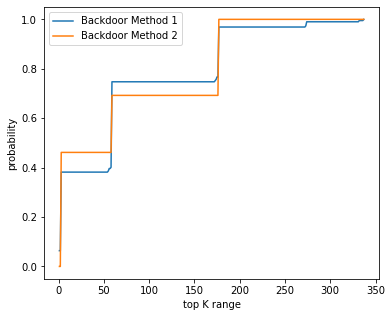

In [270]:
k_range_backdoor_val,k_range_backdoor2_val=k_range_backdoor(new_G, df, 1, {'numVotes':3}, 'averageRating', {'primaryName':2}, 'fix', [151],len(df))
x_values = range(1, len(df)+1)    
plt.figure(figsize=(6, 5))
plt.plot(x_values, k_range_backdoor_val, label='Backdoor Method 1')
plt.plot(x_values, k_range_backdoor2_val, label='Backdoor Method 2')
plt.xlabel('top K range')
plt.ylabel('probability')
plt.legend()

plt.savefig(f'ranking_plots/topk_range_backdoor.png')
plt.show()

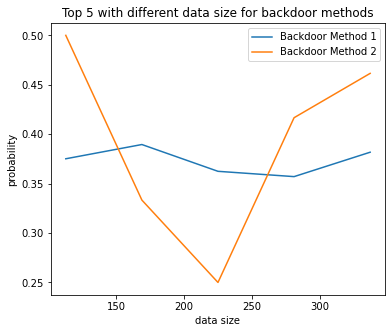

In [268]:
lenth,data_size_backdoor_val,data_size_backdoor2_val=data_size_backdoor(new_G, df, 5, {'numVotes':3}, 'averageRating', {'primaryName':2}, 'fix', [151],6,123)
plt.figure(figsize=(6, 5))
plt.plot(lenth, data_size_backdoor_val, label='Backdoor Method 1')
plt.xlabel('data size')
plt.ylabel('probability')

plt.plot(lenth, data_size_backdoor2_val, label='Backdoor Method 2')
plt.xlabel('data size')
plt.ylabel('probability')
plt.title(f'Top 5 with different data size for backdoor methods')
plt.legend()

plt.savefig(f'ranking_plots/topk_backdoor_range.png')
plt.show()

In [226]:
def Comp_Greedy_Algo_backdoor2(row_indexes,G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
    prob_result=[]
    prob_result2=[]
    if opt=='add'or 'subs':
        if opt=='add':
            pos=1
        else:
            pos=-1
        for var in vars_test:
            x_up=0
            x_sd = np.abs(df[var].std() * force)*pos
            for i in range(max_iter):
                x_up+=x_sd
                updated_df=ranking_funcs.get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
                theta=updated_df[target_column].iloc[k-1]
                prob_backdoor2=ranking_funcs.get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result2.append(prob_backdoor2)
                
    elif opt=='multiply_by'or 'divided_by':
        if opt=='divided_by':
            def op_chang(x_sd):
                return 1/x_sd
        else:
            def op_chang(x_sd):
                return x_sd    
        for var in vars_test:
            x_up=0
            x_sd = op_chang(1+np.abs(df[var].std() * force))
            for i in range(max_iter):
                x_up*=x_sd
                updated_df=ranking_funcs.get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
                theta=updated_df[target_column].iloc[k-1] 
                prob_backdoor2=ranking_funcs.get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result2.append(prob_backdoor2)
    else:
        print('invalid operator, operator must be add,subs,multiply_by and divided_by')
    return prob_result2

In [192]:
def Comp_Greedy_Algo_backdoor_edited(row_indexes,G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
    prob_result=[]
    prob_result2=[]
    if opt=='add'or 'subs':
        if opt=='add':
            pos=1
        else:
            pos=-1
        for var in vars_test:
            x_up=0
            x_sd = np.abs(df[var].std() * force)*pos
            for i in range(max_iter):
                x_up+=x_sd
                updated_df=ranking_funcs.get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
                theta=updated_df[target_column].iloc[k-1]
                prob_backdoor=ranking_funcs.get_prob_backdoor_opt(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_backdoor2=ranking_funcs.get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result.append(prob_backdoor)
                prob_result2.append(prob_backdoor2)
                
    elif opt=='multiply_by'or 'divided_by':
        if opt=='divided_by':
            def op_chang(x_sd):
                return 1/x_sd
        else:
            def op_chang(x_sd):
                return x_sd    
        for var in vars_test:
            x_up=0
            x_sd = op_chang(1+np.abs(df[var].std() * force))
            for i in range(max_iter):
                x_up*=x_sd
                updated_df=ranking_funcs.get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
                theta=updated_df[target_column].iloc[k-1] 
                prob_backdoor=ranking_funcs.get_prob_backdoor_opt(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_backdoor2=ranking_funcs.get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result.append(prob_backdoor)
                prob_result2.append(prob_backdoor2)
    else:
        print('invalid operator, operator must be add,subs,multiply_by and divided_by')
    return prob_result,prob_result2

In [194]:
var=['numVotes']
df_gr=ranking_funcs.Greedy_Algo(new_G, df, 5, 'averageRating',var,0, {'primaryName':6},100, opt="add",force=2)
df_gr

,rank,prob,total_iters
0,"[69, 249, 103, 90, 106]",0.01,1.0
1,"[69, 90, 109, 81, 106]",0.01,1.0
2,"[69, 98, 103, 84, 85]",0.02,2.0
3,"[69, 98, 85, 81, 106]",0.01,1.0
4,"[69, 98, 81, 91, 103]",0.95,95.0


In [196]:
row_indexes=[69, 98, 81, 91, 103]
greedy_backdoor,greedy_backdoor2=Comp_Greedy_Algo_backdoor_edited(row_indexes,new_G, df, 5, 'averageRating',var,1, {'primaryName':6} ,100, opt="add",force=2)

In [199]:
np.sum(greedy_backdoor)/100

0.02587897926355209

In [200]:
np.sum(greedy_backdoor2)/100

0.010457516339869282

In [201]:
row_indexes=[69, 98, 85, 81, 106]
greedy_backdoor,greedy_backdoor2=Comp_Greedy_Algo_backdoor_edited(row_indexes,new_G, df, 5, 'averageRating',var,1, {'primaryName':6} ,100, opt="add",force=2)

In [202]:
np.sum(greedy_backdoor)/100

0.0019315837925888873

In [203]:
np.sum(greedy_backdoor2)/100

0.00588235294117647

In [204]:
var=['numVotes']
df_gr_combined=ranking_funcs.Greedy_Algo(new_G_combined, df, 5, 'averageRating',var,0, {'primaryName':6},100, opt="add",force=2)
df_gr_combined

,rank,prob,total_iters
0,"[69, 90, 109, 81, 106]",0.01,1.0
1,"[69, 98, 103, 84, 85]",0.01,1.0
2,"[69, 98, 85, 81, 106]",0.01,1.0
3,"[69, 98, 81, 91, 103]",0.97,97.0


In [205]:
row_indexes=[69, 98, 81, 91, 103]
greedy_backdoor,greedy_backdoor2=Comp_Greedy_Algo_backdoor_edited(row_indexes,new_G_combined, df, 5, 'averageRating',var,1, {'primaryName':6} ,100, opt="add",force=2)

In [206]:
np.sum(greedy_backdoor)/100

0.02587897926355209

In [207]:
np.sum(greedy_backdoor2)/100

0.010457516339869282

In [208]:
row_indexes=[69, 98, 85, 81, 106]
greedy_backdoor,greedy_backdoor2=Comp_Greedy_Algo_backdoor_edited(row_indexes,new_G_combined, df, 5, 'averageRating',var,1, {'primaryName':6} ,100, opt="add",force=2)

In [209]:
np.sum(greedy_backdoor)/100

0.0019315837925888873

In [210]:
np.sum(greedy_backdoor2)/100

0.00588235294117647

In [213]:
baseline_val=ranking_funcs.base_line(df,5)**5
baseline_val

7.481291414862478e-64

/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_43059/3576897967.py:25: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[i].set_ylim(0, max_val)
/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_43059/3576897967.py:25: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[i].set_ylim(0, max_val)


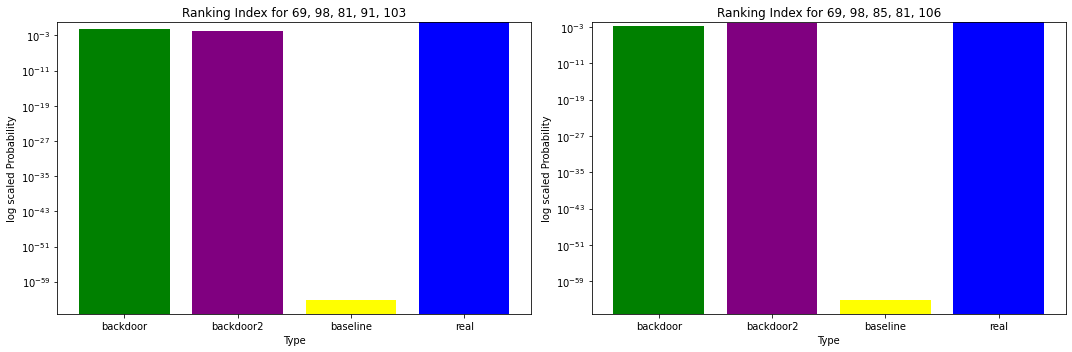

In [216]:
data1 = {'backdoor': 0.02587897926355209,'backdoor2': 0.010457516339869282, 'baseline':baseline_val,'real': 0.95}
data2 = {'backdoor': 0.0019315837925888873,'backdoor2':0.00588235294117647,  'baseline':baseline_val,'real': 0.01}

data=[data1, data2]

types = ['backdoor','backdoor2','baseline','real']
colors = {'backdoor': 'green', 'backdoor2':'purple','baseline': 'yellow','real': 'blue'}

titles = [
    "Ranking Index for 69, 98, 81, 91, 103",
    "Ranking Index for 69, 98, 85, 81, 106"
]


fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 

for i, d in enumerate(data):
    axes[i].bar(types, [d[t] for t in types], color=[colors[t] for t in types])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Type')
    axes[i].set_xticks(types)
    axes[i].set_ylabel('log scaled Probability')
    axes[i].set_yscale('log')
    max_val = max(d.values())
    axes[i].set_ylim(0, max_val)  

plt.tight_layout()
plt.savefig(f'ranking_plots/greedy_noncg.png')
plt.show()

/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_43059/4040836573.py:25: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[i].set_ylim(0, max_val)
/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_43059/4040836573.py:25: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[i].set_ylim(0, max_val)


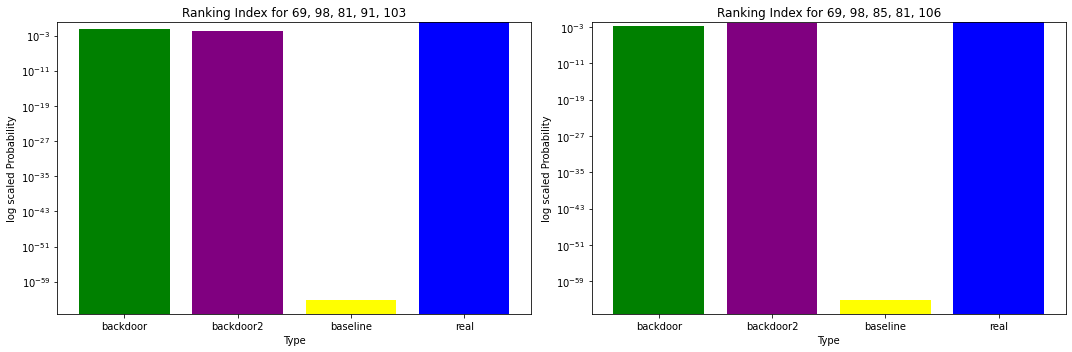

In [217]:
data1 = {'backdoor': 0.02587897926355209,'backdoor2': 0.010457516339869282, 'baseline':baseline_val,'real': 0.97}
data2 = {'backdoor': 0.0019315837925888873,'backdoor2':0.00588235294117647,  'baseline':baseline_val,'real': 0.01}

data=[data1, data2]

types = ['backdoor','backdoor2','baseline','real']
colors = {'backdoor': 'green', 'backdoor2':'purple','baseline': 'yellow','real': 'blue'}

titles = [
    "Ranking Index for 69, 98, 81, 91, 103",
    "Ranking Index for 69, 98, 85, 81, 106"
]


fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 

for i, d in enumerate(data):
    axes[i].bar(types, [d[t] for t in types], color=[colors[t] for t in types])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Type')
    axes[i].set_xticks(types)
    axes[i].set_ylabel('log scaled Probability')
    axes[i].set_yscale('log')
    max_val = max(d.values())
    axes[i].set_ylim(0, max_val)  

plt.tight_layout()
plt.savefig(f'ranking_plots/greedy_cg.png')
plt.show()

In [220]:
import time

In [222]:
df_subsets=df.head(50)
iter_times=[10,50,100,150,200,250,300,350]
var=['numVotes']
time_greedy_algo=[]

for i in iter_times:
    start_time = time.time()
    df_gr=ranking_funcs.Greedy_Algo(new_G, df_subsets, 5, 'averageRating',var,0, {'primaryName':6},i, opt="add",force=2)
    end_time = time.time()
    time_greedy_algo.append(end_time - start_time)

In [223]:
time_greedy_algo 

[0.030939817428588867,
 0.07260012626647949,
 0.13912510871887207,
 0.1926288604736328,
 0.24882984161376953,
 0.32022786140441895,
 0.37798619270324707,
 0.44417691230773926]

In [224]:
time_greedy_backdoor=[]
row_indexes=[5, 4, 6, 7, 8]

for i in iter_times:
    start_time = time.time()
    greedy_backdoor=ranking_funcs.Comp_Greedy_Algo_backdoor(row_indexes,new_G, df_subsets, 5, 'averageRating',var,1, {'primaryName':6} ,i, opt="add",force=2)
    end_time = time.time()
    time_greedy_backdoor.append(end_time - start_time)

In [225]:
time_greedy_backdoor 

[0.5724189281463623,
 2.5743799209594727,
 5.167581796646118,
 7.5478127002716064,
 10.066657066345215,
 12.754530191421509,
 15.011154174804688,
 17.491451740264893]

In [227]:
time_greedy_backdoor2=[]

for i in iter_times:
    start_time = time.time()
    greedy_backdoor=Comp_Greedy_Algo_backdoor2(row_indexes,new_G, df_subsets, 5, 'averageRating',var,1, {'primaryName':6} ,i, opt="add",force=2)
    end_time = time.time()
    time_greedy_backdoor2.append(end_time - start_time)

In [228]:
time_greedy_backdoor2

[0.45108795166015625,
 2.2165188789367676,
 4.359093189239502,
 6.408802032470703,
 8.670315980911255,
 10.137517929077148,
 12.319741010665894,
 14.309854984283447]

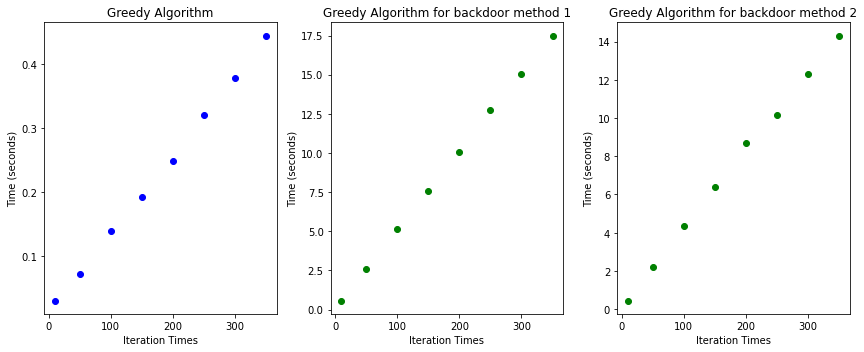

In [229]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  

axes[0].scatter(x=iter_times, y=time_greedy_algo, color='blue')
axes[0].set_title('Greedy Algorithm')
axes[0].set_xlabel('Iteration Times')
axes[0].set_ylabel('Time (seconds)')

axes[1].scatter(x=iter_times, y=time_greedy_backdoor, color='green')
axes[1].set_title('Greedy Algorithm for backdoor method 1')
axes[1].set_xlabel('Iteration Times')
axes[1].set_ylabel('Time (seconds)')

axes[2].scatter(x=iter_times, y=time_greedy_backdoor2, color='green')
axes[2].set_title('Greedy Algorithm for backdoor method 2')
axes[2].set_xlabel('Iteration Times')
axes[2].set_ylabel('Time (seconds)')

plt.tight_layout()
plt.savefig(f'ranking_plots/time_comparision_greedy.png')
plt.show()

In [273]:
df.sample(10)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,...,Documentary,Sport,Musical,Animation,Western,Mystery,History,Action,Adventure,War
96,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0800241,tt0800241,7.0,2,...,0,0,0,0,0,1,0,0,0,0
278,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt1396208,tt1396208,4.0,0,...,0,0,0,0,0,0,0,0,0,0
3,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0099487,tt0099487,8.0,3,...,0,0,0,0,0,0,0,0,0,0
23,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0285823,tt0285823,6.0,3,...,0,0,0,0,0,0,0,1,0,0
161,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt2883512,tt2883512,7.0,3,...,0,0,0,0,0,0,0,0,1,0
159,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt27766499,tt27766499,7.0,0,...,1,0,0,0,0,0,0,0,0,0
229,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0208903,tt0208903,6.0,0,...,0,0,1,0,0,0,0,0,0,0
64,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0099568,tt0099568,5.0,0,...,0,0,0,0,0,0,0,0,0,0
185,nm0452860,5,1981,\N,"actress,director,writer","tt0844286,tt1663662,tt0449467,tt3263614",tt2215676,tt2215676,6.0,0,...,0,0,0,0,0,0,0,0,0,0
283,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt1508950,tt1508950,6.0,0,...,0,0,0,0,0,0,0,1,0,0


In [280]:
df.loc[row_indexes]

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,...,Documentary,Sport,Musical,Animation,Western,Mystery,History,Action,Adventure,War
5,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0106387,tt0106387,7.0,2,...,0,0,0,0,0,0,0,0,0,0
4,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0106307,tt0106307,7.0,1,...,0,0,0,0,0,0,0,0,0,0
6,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0108550,tt0108550,8.0,3,...,0,0,0,0,0,0,0,0,0,0
7,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0109707,tt0109707,8.0,3,...,0,0,0,0,0,0,0,0,0,0
8,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0112817,tt0112817,8.0,3,...,0,0,0,0,0,0,0,0,1,0


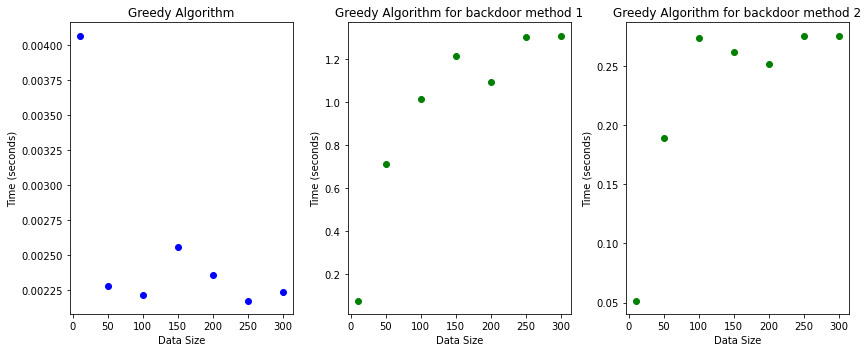

In [285]:
i_range=[10,50,100,150,200,250,300]
time_greedy_algo=[]
var=['numVotes']
time_greedy_backdoor=[]
row_indexes=[5, 4, 6, 7, 8]
time_greedy_backdoor2=[]
df_rows=df.loc[row_indexes]
df_dropped = df.copy().drop(row_indexes)

for i in i_range:
    df_subsets=pd.concat([df_dropped.sample(i-5),df_rows])

    start_time = time.time()
    df_gr=ranking_funcs.Greedy_Algo(new_G, df_subsets, 5, 'averageRating',var,0, {'primaryName':6},1, opt="add",force=2)
    end_time = time.time()
    time_greedy_algo.append(end_time - start_time)


    start_time = time.time()
    greedy_backdoor=ranking_funcs.Comp_Greedy_Algo_backdoor(row_indexes,new_G, df_subsets, 5, 'averageRating',var,1, {'primaryName':6} ,1, opt="add",force=2)
    end_time = time.time()
    time_greedy_backdoor.append(end_time - start_time)


    start_time = time.time()
    greedy_backdoor=Comp_Greedy_Algo_backdoor2(row_indexes,new_G, df_subsets, 5, 'averageRating',var,1, {'primaryName':6} ,1, opt="add",force=2)
    end_time = time.time()
    time_greedy_backdoor2.append(end_time - start_time)
    
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  

axes[0].scatter(x=i_range, y=time_greedy_algo, color='blue')
axes[0].set_title('Greedy Algorithm')
axes[0].set_xlabel('Data Size')
axes[0].set_ylabel('Time (seconds)')

axes[1].scatter(x=i_range, y=time_greedy_backdoor, color='green')
axes[1].set_title('Greedy Algorithm for backdoor method 1')
axes[1].set_xlabel('Data Size')
axes[1].set_ylabel('Time (seconds)')

axes[2].scatter(x=i_range, y=time_greedy_backdoor2, color='green')
axes[2].set_title('Greedy Algorithm for backdoor method 2')
axes[2].set_xlabel('Data Size')
axes[2].set_ylabel('Time (seconds)')

plt.tight_layout()
plt.savefig(f'ranking_plots/time_comparision_data.png')
plt.show()

In [6]:
df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,...,Documentary,Sport,Musical,Animation,Western,Mystery,History,Action,Adventure,War
0,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0087800,tt0087800,7.0,3,...,0,0,0,0,0,0,0,0,0,0
1,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0089839,tt0089839,5.0,0,...,0,0,0,0,0,0,0,0,0,0
2,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0099329,tt0099329,6.0,2,...,0,0,1,0,0,0,0,0,0,0
3,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0099487,tt0099487,8.0,3,...,0,0,0,0,0,0,0,0,0,0
4,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0106307,tt0106307,7.0,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
from random import sample

In [58]:
df_sample=df.sample(30, random_state=123)

df_sample

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,...,Documentary,Sport,Musical,Animation,Western,Mystery,History,Action,Adventure,War
201,nm0597388,4,1979,\N,"actor,producer,writer","tt5433140,tt0974015,tt1477834,tt4334266",tt4334266,tt4334266,5.0,1,...,0,0,0,0,0,1,0,1,0,0
120,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt4943322,tt4943322,6.0,1,...,0,0,0,0,0,0,0,0,0,1
173,nm0452860,5,1981,\N,"actress,director,writer","tt0844286,tt1663662,tt0449467,tt3263614",tt0965405,tt0965405,6.0,0,...,0,0,0,0,0,0,0,0,0,0
220,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0116950,tt0116950,8.0,0,...,0,0,0,0,0,0,0,1,0,0
188,nm0452860,5,1981,\N,"actress,director,writer","tt0844286,tt1663662,tt0449467,tt3263614",tt3263614,tt3263614,7.0,1,...,0,0,0,0,0,0,0,0,0,0
155,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt1798709,tt1798709,8.0,3,...,0,0,0,0,0,0,0,0,0,0
11,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0118768,tt0118768,6.0,1,...,0,0,0,0,0,0,0,0,0,0
202,nm0597388,4,1979,\N,"actor,producer,writer","tt5433140,tt0974015,tt1477834,tt4334266",tt4694544,tt4694544,5.0,1,...,0,0,0,0,0,0,0,1,1,0
298,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt3876082,tt3876082,6.0,0,...,0,0,0,0,0,0,0,0,0,0
167,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt7653254,tt7653254,8.0,3,...,0,0,0,0,0,0,0,0,0,0


In [59]:
df_sample.sort_values(by='averageRating',ascending=False)[['primaryTitle','primaryName','averageRating']]

,primaryTitle,primaryName,averageRating
249,Long Da Lishkara,7,9.0
167,Marriage Story,0,8.0
220,Maachis,7,8.0
155,Her,0,8.0
20,Blow,3,8.0
33,Pirates of the Caribbean: At World's End,3,7.0
31,Pirates of the Caribbean: Dead Man's Chest,3,7.0
9,Don Juan DeMarco,3,7.0
72,Liberation,6,7.0
291,Trafficker,7,7.0


In [30]:
sample_index=df_sample.sort_values(by='averageRating',ascending=False).index

In [31]:
sample_index

Int64Index([220, 155, 167, 188, 120, 173, 11, 298, 201, 202], dtype='int64')

In [39]:
small_list = [1, 2]
large_list = [2, 1]

set(small_list).issubset(large_list)

True

In [43]:
df_sample.head(1)['averageRating'].iloc[0]

5.0

In [ ]:
# def Comp_Greedy_Algo_backdoor_part3(row_indexes,G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
#     prob_result=0
#     prob_result2=0
#     indexes=[list(pair) for pair in itertools.combinations(df.index, k)]
#     if opt=='add'or 'subs':
#         if opt=='add':
#             pos=1
#         else:
#             pos=-1
#         for var in vars_test:
#             x_up=0
#             x_sd = np.abs(df[var].std() * force)*pos
#             for i in range(max_iter):
#                 x_up+=x_sd
#                 updated_df=get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
#                 theta=updated_df[target_column].iloc[k-1]
#                 backdoor_probs=[]
#                 backdoor_probs2=[]
#                 index_group=[]
#                 for index in indexes:
#                     prob_backdoor=get_prob_backdoor_opt(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
#                     prob_backdoor2=get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
#                     backdoor_probs.append(prob_backdoor)
#                     backdoor_probs2.append(prob_backdoor2)
#                     index_group.append(index)
#                 prob_df=pd.DataFrame({'backdoor_1':backdoor_probs,
#                                      'backdoor_2':backdoor_probs2,
#                                      'index':index_group})
#                 prob_df['sorted_index'] = prob_df['index'].apply(lambda x: sorted(x))
#                 row = prob_df[prob_df['sorted_index'] == row_indexes]
                
#                 if row['backdoor_1'].iloc[0] == prob_df['backdoor_1'].max():
#                     prob_result+=1
                    
#                 if row['backdoor_2'].iloc[0] == prob_df['backdoor_2'].max():
#                     prob_result2+=1
                
                
#     elif opt=='multiply_by'or 'divided_by':
#         if opt=='divided_by':
#             def op_chang(x_sd):
#                 return 1/x_sd
#         else:
#             def op_chang(x_sd):
#                 return x_sd    
#         for var in vars_test:
#             x_up=0
#             x_sd = op_chang(1+np.abs(df[var].std() * force))
#             for i in range(max_iter):
#                 x_up*=x_sd
#                 updated_df=get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
#                 theta=updated_df[target_column].iloc[k-1] 
#                 backdoor_probs=[]
#                 backdoor_probs2=[]
#                 index_group=[]
#                 for index in indexes:
#                     prob_backdoor=get_prob_backdoor_opt(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
#                     prob_backdoor2=get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
#                     backdoor_probs.append(prob_backdoor)
#                     backdoor_probs2.append(prob_backdoor2)
#                     index_group.append(index)
#                 prob_df=pd.DataFrame({'backdoor_1':backdoor_probs,
#                                      'backdoor_2':backdoor_probs2,
#                                      'index':index_group})
#                 prob_df['sorted_index'] = prob_df['index'].apply(lambda x: sorted(x))
#                 row = prob_df[prob_df['sorted_index'] == row_indexes]
                
#                 if row['backdoor_1'].iloc[0] == prob_df['backdoor_1'].max():
#                     prob_result+=1
                    
#                 if row['backdoor_2'].iloc[0] == prob_df['backdoor_2'].max():
#                     prob_result2+=1
#     else:
#         print('invalid operator, operator must be add,subs,multiply_by and divided_by')
#     return prob_result/max_iter,prob_result2/max_iter

In [36]:
df_sample['averageRating'].idxmax()

220

In [89]:
for i in range(6):
    tok_k_prob_df = ranking_funcs.get_ranking_query_prob(new_G, df, 3, {'numVotes':i}, 'averageRating',{'primaryTitle':'Captain America: The Winter Soldier'},'fix')
    top3_ranking_probs = ranking_funcs.filter_prob_df(tok_k_prob_df)
    print(i)
    print('---------------')
    for idx in [69, 156, 249]:
        if idx in top3_ranking_probs.index:
            print(top3_ranking_probs.loc[idx])
        else:
            print(f"Index {idx} not found.")

0
---------------
row_index    69.0
1             0.5
2             0.5
3             0.0
Name: 69, dtype: float64
Index 156 not found.
row_index    249.0
1              0.5
2              0.5
3              0.0
Name: 249, dtype: float64
1
---------------
row_index    69.0
1             0.5
2             0.5
3             0.0
Name: 69, dtype: float64
Index 156 not found.
row_index    249.0
1              0.5
2              0.5
3              0.0
Name: 249, dtype: float64
2
---------------
row_index    69.0
1             0.5
2             0.5
3             0.0
Name: 69, dtype: float64
Index 156 not found.
row_index    249.0
1              0.5
2              0.5
3              0.0
Name: 249, dtype: float64
3
---------------
row_index    69.0
1             0.5
2             0.5
3             0.0
Name: 69, dtype: float64
row_index    156.000000
1              0.000000
2              0.000000
3              0.019231
Name: 156, dtype: float64
row_index    249.0
1              0.5
2          

In [91]:
0.5*0.5*1

1

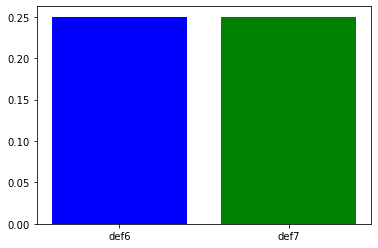

In [2]:
data = {'def6': 0.25, 'def7': 0.25}

labels = list(data.keys())
heights = list(data.values())

colors = ['blue', 'green']  


plt.bar(labels, heights, color=colors)

plt.savefig(f'ranking_plots/two_def.png')
plt.show()

In [96]:
ranking_funcs.get_ranking_query_prob_grouped(new_G, df, 3, {'numVotes':3},  'averageRating', 'primaryName', {'primaryName':5},'fix')

,group_col,1,2,3
0,0,0,1,0
1,1,0,0,0
2,2,0,0,0
3,3,0,0,1
4,4,0,0,0
5,5,1,0,0
6,6,0,0,0
7,7,0,0,0


In [98]:
stable_rank_fix=ranking_funcs.get_stable_ranking_opt(new_G, df, 3, {'numVotes':3}, 'averageRating',{'primaryName':5},100,'multiply_by')
stable_rank_fix

Lower Bound Change: (Value: 2.09506077936651, Iteration: 29)
Upper Bound Change: (Value: 3.231331561892627, Iteration: 6)


[[2.09506077936651, 3.231331561892627], [29, 6]]

In [100]:
ranking_funcs.get_test_revert_ranking_rec(new_G, df, 3, {'numVotes':3}, 'averageRating',{'primaryName':5},
                            stable_rank_fix,1000,0,3,'low','divided_by')

no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000


'the iteration ends'

# Experiment

### Datasets 

We give a short description of the datasets and baselines used in
this section.
- German dataset [20] contains details of bank account holders including demographic and financial information along with their credit risk. It composed of a single table and the
causal graph was used from [11].

- Amazon book dataset contains details of books in computer area including publication and edition information along with their ratings. The causal graph was generated from ChatGPt.

- IMDB dataset contains details of movies and television works including the eposides length and actor information along with their ratings. We merge the datasets from the IMDB website and filter the movies acted by 'Scarlett Johansson', 'Emma Mackey', 'Margot Robbie', 'Johnny Depp', 'Jason Momoa', 'Rinko Kikuchi', 'Ben Kingsley' and 'Om Puri'.

primaryName (actor's name): A well-known actor may influence both the averageRating and numVotes a movie receives due to their popularity. They might also have a preference or typecasting for certain genres (Comedy, Horror, Fantasy, Action), which could influence the types of movies they act in.

averageRating: This might be influenced by the primaryName, numVotes, and the startYear (as movies from different eras may be rated differently). The genres of the movie could also affect its rating.

numVotes: This is likely influenced by the primaryName and the averageRating (as higher-rated movies may attract more voters). The startYear could also affect the number of votes due to the changing population of moviegoers and the ways movies are rated over time.

startYear: This reflects the era in which the movie was released. It can influence the runtimeMinutes (as movie lengths can vary by era), and it could also influence the averageRating and numVotes due to changes in the audience and rating systems over time.

runtimeMinutes: This might be a factor in the averageRating, as the length of a movie can affect audience satisfaction. It might also be associated with specific genres since some genres, like Fantasy or Action, might typically have longer runtimes.

Comedy, Horror, Fantasy, Action (genres): The presence of these genres could be a result of the primaryName if the actor tends to be cast in certain types of movies. These genres might also affect the averageRating since audience preferences can vary by genre.

The causal garph was generated from ChatGPt. 

![causal graph for imdb](ranking_plots/causal_graph_imdb.png)

### Variations

#### Overview of Hypothetical Update 
The foundation of our approach was the construction and utilization of a causal graph, derived from the dataset using Ordinary Least Squares (OLS) regression. This step was crucial in identifying and mapping out the causal relationships between various variables within the dataset. With the causal graph established, we  proceeded to apply a technique we termed "hypothetical update." This involved systematically altering specific variables within the database, following predetermined scenarios. The purpose of these updates was twofold: firstly, to simulate the impact of potential real-world changes within the data environment, and secondly, to observe and meticulously record the shifts in the top k results arising from these hypothetical changes. This approach was instrumental in allowing us to predict the effects of variable manipulation, offering valuable insights into the causal dynamics at play within the dataset.

#### Overview of Stable Ranking 
Our stable ranking analysis was predicated on a robust and iterative algorithmic process. The objective was to critically examine the resilience and consistency of the ranking system in response to ongoing modifications of a chosen variable. To this end, we developed the `get_stable_ranking_opt` algorithm, which was designed to be highly adaptable, allowing for a variety of operations on the variable under scrutiny (such as fixing, multiplying, dividing, adding, and subtracting). Central to this methodology was the recursive function `test_revert_ranking_rec`. This function facilitated repeated and controlled adjustments to the variable, enabling us to analyze the stability of the rankings over multiple iterations, under an array of distinct conditions and scenarios. The ultimate goal was to ascertain the robustness of the ranking mechanism and its susceptibility to changes in variable states.

#### Overview of Group Ranking 
In our group ranking strategy, we shifted our focus from individual to group-based rankings. This method involved segmenting entities into groups based on shared characteristics, then analyzing the rankings within these groups. This approach was particularly advantageous in datasets where group attributes significantly influenced ranking outcomes. By categorizing items into distinct groups and evaluating the rankings therein, we were able to uncover deeper insights and patterns that might remain concealed in individual rankings. This group-based analysis allowed for a more granular understanding of the data, revealing how group characteristics can impact overall ranking dynamics.

#### Overview of Greedy Algorithm & Backdoor Criterion
To further explore the intricacies of ranking changes, we implemented a greedy algorithm. This iterative method involved continuously updating a chosen variable and closely monitoring the resultant shifts in ranking. The aim was to capture the immediate and incremental impacts of these variable changes on the overall ranking structure. Complementing this approach, we employed the backdoor criterion. This sophisticated statistical technique was used to calculate the probabilities of certain rankings occurring. It took into account indirect causal paths (backdoor paths) within the causal graph. By incorporating this criterion, we were able to provide a more comprehensive and nuanced understanding of ranking probabilities under a variety of scenarios and conditions.

#### Baseline
The baseline for any row's probility being in top k is $prob_{baseline}=\frac{1}{perm(len(df), k)}$. Then any n rows being in being in top k we have $prob_{baseline}^n$.

#### Backdoor method 1
To estimate the probility of top k rank in backdoor method 1. For the backdoor sets we have $\sum_{i=1}^{n}Pr(Y=y|do(X)=x,Z=z_i)Pr(Z=z_i)$ to calculate $Pr(Y=y|do(X)=x)$Then we calculate $\sum_{j=1}^{n}Pr(Y=y_j|do(X)=x)$ with $y_j \geq \theta$. Then we assign these probability to the rows we want to calculated in the updated dataframe with their do(X)=x. Then we calculate the product of them to get the $Pr(r1>=theta,r2>=theta,...|do(X))$ . 

#### Backdoor method 2
To estimate the probility of top k rank in backdoor method 2. For the backdoor sets we have $Pr(Y=y|do(X)=x,Z=z)$ Then we calculate $\sum_{j=1}^{n}Pr(Y=y_j|do(X)=x,Z=z)$ with $y_j \geq \theta$. Then we assign these probability to the rows we want to calculated in the updated dataframe with their do(X)=x and Z=z. Then we calculate the product of them to get the $Pr(r1>=theta,r2>=theta,...|do(X))$ . 

##### Condtions for backdoor method 1 and backdoor method2.
The backdoor method 2 is equavlent to backdoor method 1 if $Pr(Y=y|do(X)=x,Z=z_1)=Pr(Y=y|do(X)=x,Z=z_2)=... = Pr(Y=y|do(X)=x,Z=z_n)$. Proof. Since  $P=Pr(Y=y|do(X)=x,Z=z_1)=Pr(Y=y|do(X)=x,Z=z_2)=... = Pr(Y=y|do(X)=x,Z=z_n)$ and $\sum_{i=1}^{n}Pr(Z=z_i)=1$. Then we have $P\sum_{i=1}^{n}Pr(Z=z_i) = P$ for any z value. Thus we have proved the backdoor method 2 is equavlent to backdoor method 1 for the given condition.

For the condtions at least one pair of $Pr(Y=y|do(X)=x,Z=z_i) \neq Pr(Y=y|do(X)=x,Z=z_j)$. We can see that backdoor method 2 have more variated probility for assigining rows that we assigning the same probility for rows with do(X)=x and Z=z. This means that we make these rows in to smaller groups compared with just assigning same probility for rows with do(X)=x. This indicates that backdoor method 2 are more easily being overifitting than backdoor method 1 in this condition.

#### Naiive approach
We fit the linear regression from the causal graph. Then the dataframe will be updated with the corresponding coeffecient and show the updated top k ranking.


### Methods

#### Quality of solutions

##### Experiment set ups
To compare the quality of solutions. We setted two experiments for each dataset. The first experiment is that we use backdoor methods and random forest to predict the actual ranking. Then we can calcualte the accuracy for each method. The second experiment is that we use backdoor methods to predict the probility for top k ranking. For each backdoor method, we fits the two causal graph for them. The two causal graphs share the same structure, but one does not consider the combined effects. For the casual graph with no combined effects, we fit the simple linear regression between $x_i$ and $x_j$ for each $x_i$ caused the $x_j$ in the causal graph. For the causal graph with combined effects, we fit the linear regression between $x_i$s and $x_j$ for each $x_i$ caused the $x_j$ in the causal graph. The true ranking that we use to compare here is the naiive approcah. To compare the performance in predicting top k, we have two metrics. One is called top k accuracy which means the exacact accuracy for the predicted ranking compared to the actual ranking. The second one is called in top k accuracy which means the accuracy for predicted ranking in true ranking irrevalent the exact order. For example, we have the true ranking is [1,2,3] and the predicted ranking is [1,3,2]. Then the top k accuracy for this example is 1/3 and the in top k accuracy is 1.

##### Experiment examples
IMDB. After finding the optimzed hyper parameters. We fit the random forests regression by using all the feautres in the causal graph. We use the fitted random forests regression to predict the average rating of the updated dataframe then sorting it to get the predicted rank. Then we also get the predicted ranks for backdoor method 1 and backdoor method 2..  The update we choosed is to replacing the actor from Scarlett Johansson with Rinko Kikuchi in "Ghost in the Shell" and the causal graph is for ignoring the combined effect. This change is considered because "Ghost in the Shell" is adapted from Japanese manga, and the character Johansson portrays is Japanese. Trough the 5 methods comparision plots for these two metrics[figure1],[figure2]. We find out that the backdoor method 2 with the causal graph having combined effects perform best in both metrics.

![In top k accuracy](ranking_plots/In_top_k_comparison.png) ![top k accuracy](ranking_plots/top_k_comparison.png)
![image.png](attachment:b8217fc3-ab2f-4d14-9f16-39084f6fbacd.png)
To look closer in the performance in different subsets. We access different groups through the each features for the backdoor method 2 with the causal graph having combined effects and the random forests. We find out that they have similar performance for most groups on top 5 comparision, but the backdoor method 2  performs better on in-top-5 comparision. This states the backdoor method here has the advantage on predict the top 5 without the order.

![in top 5 comparisions](ranking_plots/in_top_5_comparison_all_features.png)
![top 5 comparisions](ranking_plots/top_5_comparison_all_features.png)

For the experiment 2, we estimate the probability for each row in top 5 (cumulating the probility for being top 1 to 5). We use greedy method to accomplete this by iteratively updating the dataframe 100 times and record each time's top 5 ranking. The updates we made are continoulsy adding 2*std(numvotes) for numvotes for the movies acted by Ben Kingsley. We see that the backdoor method 1 more close than backdoor method 2. 
![top 5 probability comaprison with non-combined effects G](ranking_plots/greedy_noncg.png) 
![top 5 probability comaprison with combined effects](ranking_plots/greedy_cg.png)

Furthermore, we update all the movies for Margot Robbie to more than 100000 votings. Then we calculate the probability change for Ghost in the Shell for being in top k for k from 2 to all. We see a monotically increase for both methods, but the method 2 converges faster in the biggining than method 1. We also calcualte the probability of Ghost in the Shell in top 5 for different data size. To accomplish it, we split the data in to 6 folds and calcualate the probability for combine 1 more fold in each iteration. The backdoor method 2 has a more fluctuated change than backdoor method 1 by increasing the data size.

![top k range](ranking_plots/topk_range_backdoor.png) ![top 5 different datasize](ranking_plots/topk_backdoor_range.png)


#### Run time for solutions

##### Experiment set ups
We set two experiments in this part to evalute the efficiency for these metods. The first is giving the fixed data size and see the time by increasing the iterations. The second experiment is detecting the increase in time by changing the data size.

##### Experiment examples
IMDB. We iteratively increase the numbers of votings for Ben Kingsley's movies. We use greedy algorithms to compare the  backdoor methods on updates and the the naiive approach. We find out that the running time for both backdoor methods and the naiive approach are linearly increase by increasing the iterations. Backdoor method 2 is slightly faster than backdoor method 1. This is because in backdoor method 2, we do not have to calculate $\sum_{i=1}^{n}Pr(Y=y|do(X)=x,Z=z_i)Pr(Z=z_i)$ which saves the time.

![time comparision greedy](ranking_plots/time_comparision_greedy.png)

For the second experiment that we do not see the any pattern increasing in time by increase the data size. This is because the backdoor criterions's complexity are based on the unique values in the updated columns and the backdoor path sets. When there are more more unique values in the updated columns and the backdoor path sets, we will have more groups corresponding to do(X)=x for backdoor method 1, and do(X)=x, Z=z for backdooor method 2.

![time co11mparision data size](ranking_plots/time_comparision_data.png)

#### Difference result from the two different definitions

##### Experiment setups
For the top K defintions, we have definition 6 and definition 7. We give a list of tuples with independ updates and dependent updates.Then we verify it through modifying the the greedy algorithm to simulate the possible worlds. In this experiment, we will also include the group ranking and stable ranking.

IMDB. We continously update the numvotes for the movie Captain America: The Winter Soldier and find the what-if update to maximize the probability of the possible world that Schindler's List,Long Da Lishkara and Captain America: The Winter Soldier are the top 3. These tupples are considered independent. Since the update is only for a single movie which means it will not affect other movies' average rating. Then from definition 6, we get Schindler's List,Long Da Lishkara and Captain America: The Winter Soldier are in top 3 is 1. Then we calculate the probability for the probability for these tree tuples are in top k by spearating calcualte post-update distribution for these tuples and also get 1.

![definition comparision](ranking_plots/two_def.png)

IMDB. We update all Rinko Kikuchi's movies' numvotes to 3 and get the the ranking grouped by the actors. We get Rinko Kikuchi's movies have the highest avergae rating followed by Scarlett Johansson and Johnny Depp.

IMDB. We

In [ ]:
1